In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib

In [3]:
import os
import logging
import argparse
import glob
import json
from multiprocessing import Pool

import numpy as np
from matplotlib.ticker import StrMethodFormatter
from scipy import stats, integrate
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
import pandas as pd
from astropy.table import Table  # for NSA
from astropy import units as u
from sklearn.metrics import confusion_matrix, roc_curve
from PIL import Image
from scipy.stats import binom
from IPython.display import display, Markdown
import statsmodels.api as sm

from shared_astro_utils import astropy_utils, matching_utils
from zoobot.estimators import make_predictions, bayesian_estimator_funcs
from zoobot.tfrecord import read_tfrecord
from zoobot.uncertainty import discrete_coverage
from zoobot.estimators import input_utils, losses
from zoobot.tfrecord import catalog_to_tfrecord
from zoobot.active_learning import metrics, simulated_metrics, acquisition_utils, check_uncertainty, simulation_timeline, run_estimator_config
from zoobot.active_learning import acquisition_utils

In [4]:
os.chdir('/home/walml/repos/zoobot')

In [5]:

questions = [
    'smooth-or-featured',
    'has-spiral-arms',
#     'spiral-winding',
    'bar',
    'bulge-size'
]

In [6]:
# gz2 cols
version = 'gz2'
label_cols = [
    'smooth-or-featured_smooth',
    'smooth-or-featured_featured-or-disk',
    'has-spiral-arms_yes',
    'has-spiral-arms_no',
    'bar_yes',
    'bar_no',
    'bulge-size_dominant',
    'bulge-size_obvious',
    'bulge-size_just-noticeable',
    'bulge-size_no'
]

# label_cols = [
#     'smooth-or-featured_smooth',
#     'smooth-or-featured_featured-or-disk',
#     'has-spiral-arms_yes',
#     'has-spiral-arms_no',
# #     'spiral-winding_tight',
# #     'spiral-winding_medium',
# #     'spiral-winding_loose',
#     'bar_strong',
#     'bar_weak',
#     'bar_no',
#     'bulge-size_dominant',
#     'bulge-size_large',
#     'bulge-size_moderate',
#     'bulge-size_small',
#     'bulge-size_none'
# ]
# version = 'decals'

In [7]:
schema = losses.Schema(label_cols, questions, version=version)
schema.questions

{smooth-or-featured, indices 0 to 1, asked after None: (0, 1), has-spiral-arms, indices 2 to 3, asked after <zoobot.estimators.losses.Answer object at 0x7f69979ee9d0>: (2, 3), bar, indices 4 to 5, asked after <zoobot.estimators.losses.Answer object at 0x7f69979ee9d0>: (4, 5), bulge-size, indices 6 to 9, asked after <zoobot.estimators.losses.Answer object at 0x7f69979ee9d0>: (6, 9)}


[smooth-or-featured, indices 0 to 1, asked after None,
 has-spiral-arms, indices 2 to 3, asked after <zoobot.estimators.losses.Answer object at 0x7f69979ee9d0>,
 bar, indices 4 to 5, asked after <zoobot.estimators.losses.Answer object at 0x7f69979ee9d0>,
 bulge-size, indices 6 to 9, asked after <zoobot.estimators.losses.Answer object at 0x7f69979ee9d0>]

In [8]:
df_a = pd.read_csv('temp/dirichlet_concentrations_arc.csv')
df_b = pd.read_csv('temp/dirichlet_concentrations_arc_b.csv')
# df_both = pd.concat([df_a, df_b], axis=0)

In [9]:
def get_concentrations(df, answer_text):
    return np.array([json.loads(x) for x in df[answer_text + '_concentration']])

In [10]:
def get_all_concentrations(df, schema):
    concentrations = []
    for a in schema.answers:
        concentrations.append(np.array([json.loads(x) for x in df[a.text + '_concentration']]))
    return np.array(concentrations).transpose(1, 0, 2).astype(np.float32)

In [11]:
df_a_conc = get_all_concentrations(df_a, schema)
df_b_conc = get_all_concentrations(df_b, schema)
df_a_conc.shape

(1000, 10, 15)

In [12]:
df_a_conc[0, 0], df_b_conc[0, 0]

(array([3.0939202, 3.3646133, 2.7370853, 4.1778584, 3.7256372, 3.9402313,
        3.8847897, 3.5774798, 3.737917 , 4.3066607, 4.496329 , 6.03914  ,
        4.7429967, 3.719915 , 2.5809593], dtype=float32),
 array([ 6.310928 ,  7.8215284, 10.363756 ,  7.434764 ,  7.7942967,
         5.584061 ,  7.351217 , 11.533844 ,  6.8894005,  5.904443 ,
         6.698956 ,  6.6273017,  8.828017 , 10.440006 ,  6.4542365],
       dtype=float32))

In [13]:
expected_a = acquisition_utils.dirichlet_prob_of_answers(df_a_conc, schema)
for a_n, a in enumerate(schema.answers):
    df_a[a.text + '_prediction_mean'] = expected_a[:, a_n]
    
expected_b = acquisition_utils.dirichlet_prob_of_answers(df_b_conc, schema)
for a_n, a in enumerate(schema.answers):
    df_b[a.text + '_prediction_mean'] = expected_b[:, a_n]

(0.0, 0.5)

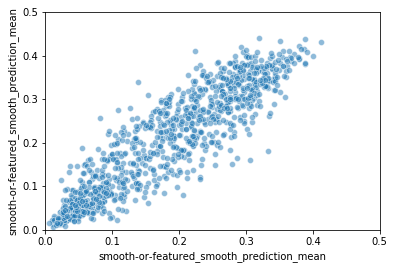

In [14]:
sns.scatterplot(df_a['smooth-or-featured_smooth_prediction_mean'], df_b['smooth-or-featured_smooth_prediction_mean'], alpha=0.5)
plt.xlim([0., 0.5])
plt.ylim([0., 0.5])

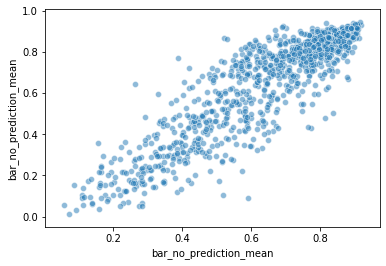

In [15]:
sns.scatterplot(df_a['bar_no_prediction_mean'], df_b['bar_no_prediction_mean'], alpha=0.5)

In [16]:
import tensorflow_probability as tfp

In [17]:
question = schema.get_question('smooth-or-featured')
# question = schema.get_question('has-spiral-arms')
# question = schema.get_question('bar')
answer = question.answers[0]

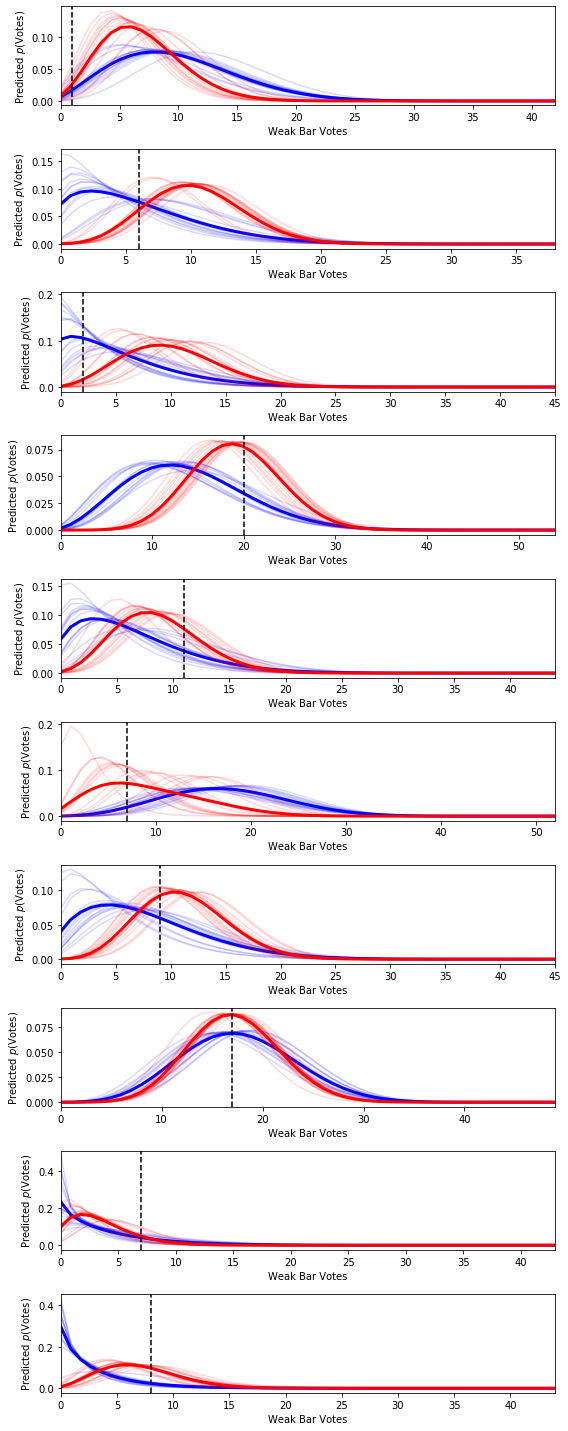

In [19]:

fig, axes = plt.subplots(nrows=10, figsize=(8, 20))
for n in range(10):
    
    ax = axes[n]
    
    galaxy = df_a.iloc[n]
    total_votes = float(galaxy[question.text+'_total-votes'])
    observed_value = df_a[answer.text].iloc[n]
    
    votes = np.linspace(0., total_votes)
    x = np.stack([votes, total_votes-votes], axis=-1)  # also need the counts for other answer, no
    votes_this_answer = x[:, answer.index - question.start_index]

    all_log_probs = []
    for d in range(15):
        concentrations = tf.constant(df_a_conc[n, question.start_index:question.end_index+1, d].astype(np.float32))
        log_probs = tfp.distributions.DirichletMultinomial(total_votes, concentrations).prob(x)
        all_log_probs.append(log_probs)
        ax.plot(votes_this_answer, log_probs, alpha=.15, color='b')
    all_log_probs = np.array(all_log_probs).mean(axis=0)
    ax.plot(votes_this_answer, all_log_probs, linewidth=3., color='b')
    
    all_log_probs = []
    for d in range(15):
        concentrations = tf.constant(df_b_conc[n, question.start_index:question.end_index+1, d].astype(np.float32))
        log_probs = tfp.distributions.DirichletMultinomial(total_votes, concentrations).prob(x)
        all_log_probs.append(log_probs)
        ax.plot(votes_this_answer, log_probs, alpha=.15, color='r')
    all_log_probs = np.array(all_log_probs).mean(axis=0)
    ax.plot(votes_this_answer, all_log_probs, linewidth=3., color='r')

    ax.axvline(observed_value, color='k', linestyle='--')
    ax.set_xlim(0., total_votes)
    
    ax.set_xlabel(answer.text + ' Votes')
#     ax.set_xlabel('Weak Bar Votes')
    ax.set_ylabel(r'Predicted $p$(Votes)')
    
#     ax.set_title('Mutual Info: ' + str(np.around(df_a[question.text + '_acquisition'].iloc[n], 2)))
    
fig.tight_layout()

In [88]:
# samples_list = [df_a_conc[:50], df_b_conc[:50]]
samples_list = [df_a_conc, df_b_conc]
mi, predictive, expected = acquisition_utils.get_multimodel_acq(samples_list, schema)

smooth-or-featured
Calculating predictive entropy
Calculating expected entropy
has-spiral-arms
Calculating predictive entropy
Calculating expected entropy
bar
Calculating predictive entropy
Calculating expected entropy
bulge-size
Calculating predictive entropy
Calculating expected entropy


In [89]:
mi.shape

(1000, 4)

In [90]:
acquisition_values = mi

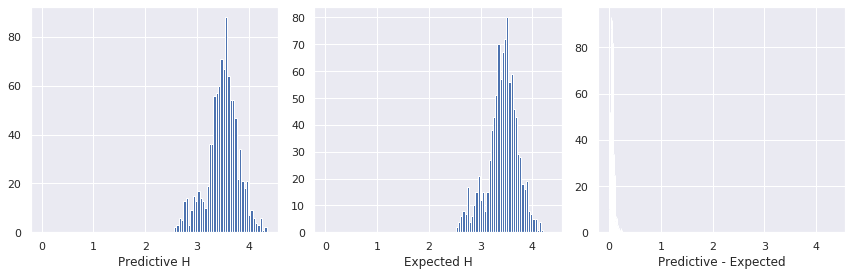

In [91]:
sns.set()
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharex=True)

axes[0].hist(predictive.mean(axis=1), bins=40)
axes[0].set_xlabel('Predictive H')

axes[1].hist(expected.mean(axis=1), bins=40)
axes[1].set_xlabel('Expected H')

axes[2].hist(acquisition_values.mean(axis=1), bins=40)
axes[2].set_xlabel('Predictive - Expected')

fig.tight_layout()

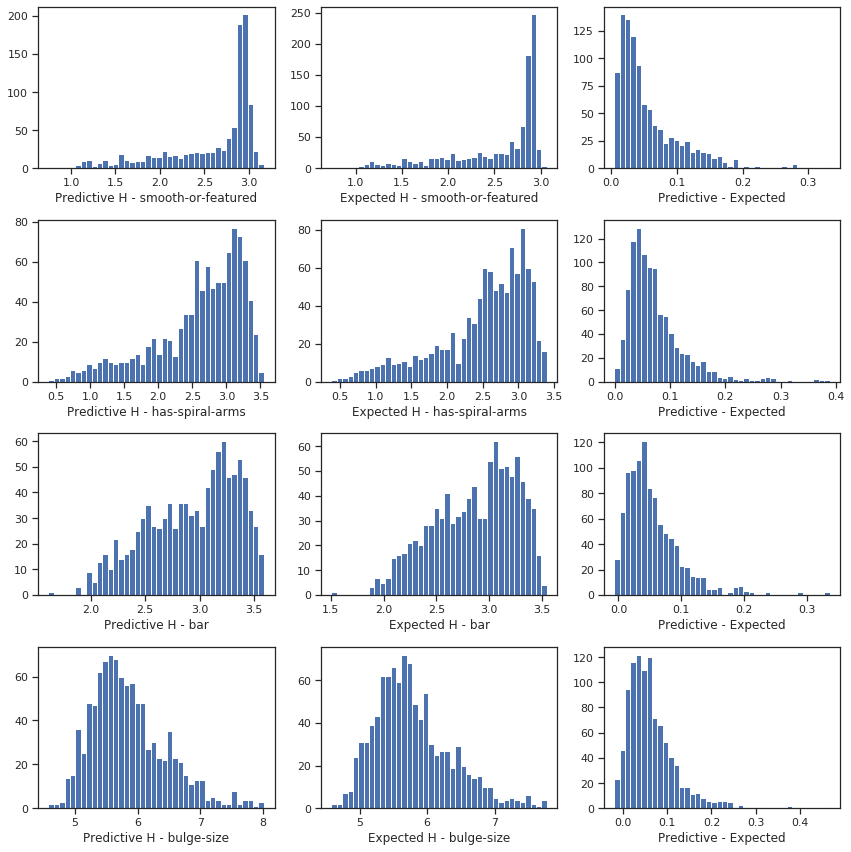

In [92]:
sns.set_style('ticks')

n_questions = len(schema.questions)
fig, axes = plt.subplots(nrows=n_questions, ncols=3, figsize=(12, 12))

for question_n, question in enumerate(schema.questions):
    row = axes[question_n]
    
    predictive_q = predictive[:, question_n]
    expected_q = expected[:, question_n]
    acq_q = acquisition_values[:, question_n]

    row[0].hist(predictive_q, bins=40)
    row[0].set_xlabel('Predictive H - ' + question.text)

    row[1].hist(expected_q, bins=40)
    row[1].set_xlabel('Expected H - ' + question.text)

    row[2].hist(acq_q, bins=40)
    row[2].set_xlabel('Predictive - Expected')

fig.tight_layout()

In [93]:
acquisition_values.mean(axis=0)

array([0.05613989, 0.07258373, 0.05500893, 0.0630757 ], dtype=float32)

In [94]:
np.isnan(acquisition_values.mean(axis=0)).sum()

0

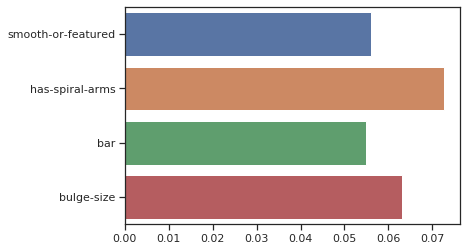

In [95]:
sns.barplot(x=acquisition_values.mean(axis=0), y=[q.text for q in schema.questions])

In [96]:
for question_n, question in enumerate(schema.questions):
    df_a[question.text + '_acquisition'] = acquisition_values[:, question_n]
df_a['acquisition_mean'] = acquisition_values.mean(axis=1)

In [97]:
df_a['file_loc_gz2'] = df_a['file_loc'].apply(lambda x: x.replace('decals/png_native', 'gz2/png' ))

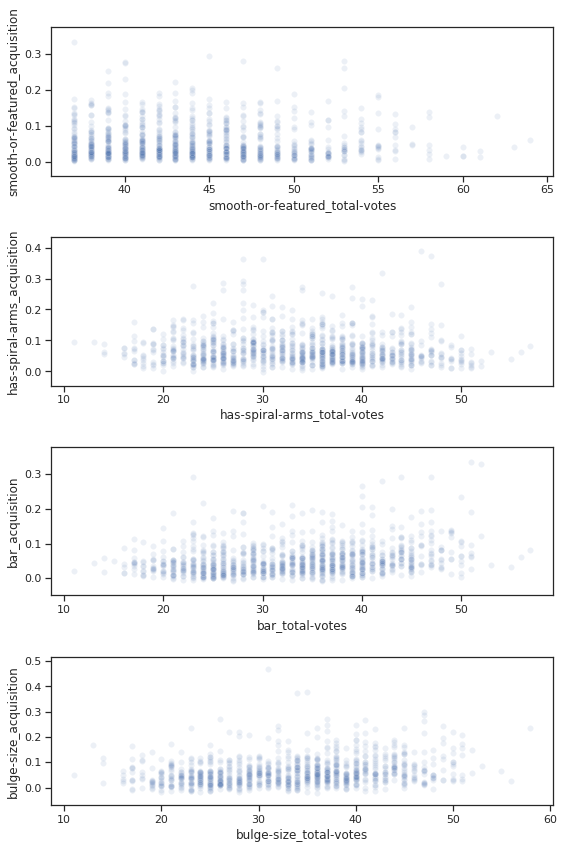

In [119]:
fig, axes = plt.subplots(nrows=n_questions, figsize=(8, 12))

for question_n in range(n_questions):
    sns.scatterplot(data=df_a, x=schema.questions[question_n].text + '_total-votes', y=schema.questions[question_n].text + '_acquisition', ax=axes[question_n], alpha=.1)
fig.tight_layout()

In [114]:
# question = schema.get_question('smooth-or-featured')
# question = schema.get_question('has-spiral-arms')
question = schema.get_question('bar')
answer = question.answers[0]

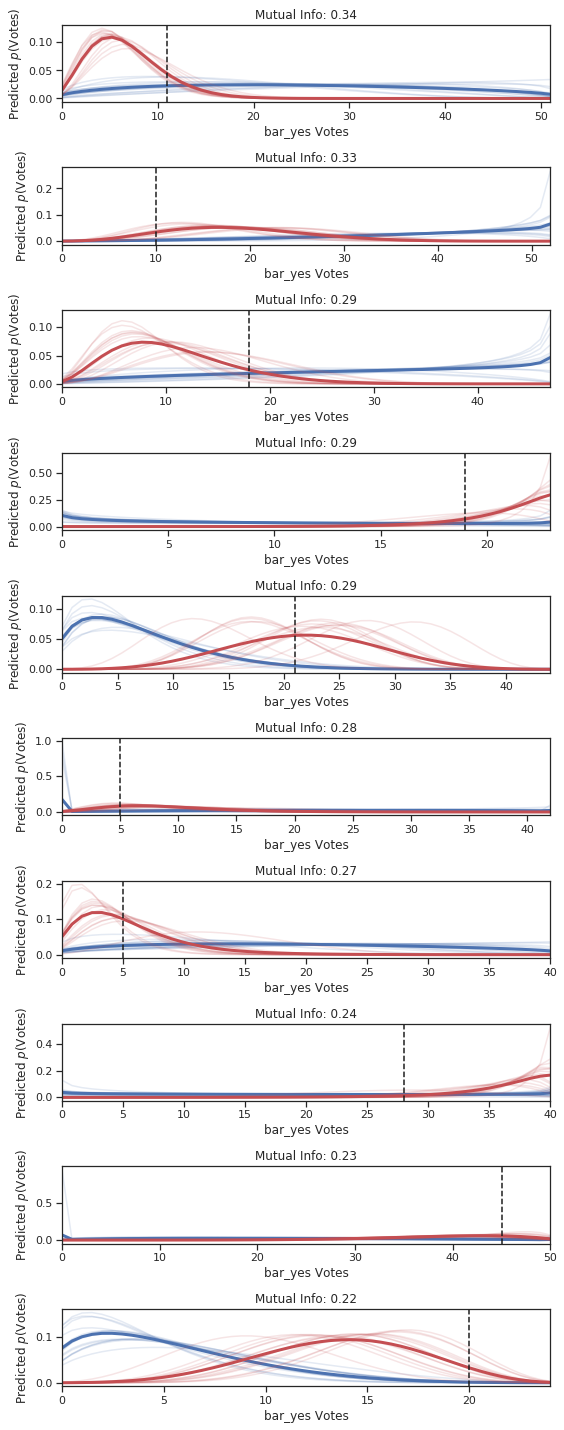

In [120]:


# mi_argsort = np.argsort(df_a[question.text + '_acquisition'])
mi_argsort = np.argsort(df_a[question.text + '_acquisition'])[::-1]


fig, axes = plt.subplots(nrows=10, figsize=(8, 20))
for n in range(10):
    
    ax = axes[n]
    
    galaxy = df_a.iloc[mi_argsort].iloc[n]
    total_votes = float(galaxy[question.text+'_total-votes'])
    observed_value = galaxy[answer.text]
    
    votes = np.linspace(0., total_votes)
    x = np.stack([votes, total_votes-votes], axis=-1)  # also need the counts for other answer, no
    votes_this_answer = x[:, answer.index - question.start_index]

    all_log_probs = []
    for d in range(15):
        concentrations = tf.constant(df_a_conc[mi_argsort][n, question.start_index:question.end_index+1, d].astype(np.float32))
        log_probs = tfp.distributions.DirichletMultinomial(total_votes, concentrations).prob(x)
        all_log_probs.append(log_probs)
        ax.plot(votes_this_answer, log_probs, alpha=.15, color='b')
    all_log_probs = np.array(all_log_probs).mean(axis=0)
    ax.plot(votes_this_answer, all_log_probs, linewidth=3., color='b')
    
    all_log_probs = []
    for d in range(15):
        concentrations = tf.constant(df_b_conc[mi_argsort][n, question.start_index:question.end_index+1, d].astype(np.float32))
        log_probs = tfp.distributions.DirichletMultinomial(total_votes, concentrations).prob(x)
        all_log_probs.append(log_probs)
        ax.plot(votes_this_answer, log_probs, alpha=.15, color='r')
    all_log_probs = np.array(all_log_probs).mean(axis=0)
    ax.plot(votes_this_answer, all_log_probs, linewidth=3., color='r')

    ax.axvline(observed_value, color='k', linestyle='--')
    ax.set_xlim(0., total_votes)
    
    ax.set_xlabel(answer.text + ' Votes')
#     ax.set_xlabel('Weak Bar Votes')
    ax.set_ylabel(r'Predicted $p$(Votes)')
    
    ax.set_title('Mutual Info: ' + str(np.around(df_a[question.text + '_acquisition'].iloc[mi_argsort].iloc[n], 2)))
    
fig.tight_layout()

In [127]:
# copied from trust_the_model.ipynb
def show_galaxies(df, scale=3, nrows=3, ncols=3):
    fig = plt.gcf()

    plt.figure(figsize=(scale * nrows, scale * ncols * 1.025))
    gs1 = gridspec.GridSpec(nrows, ncols)
    gs1.update(wspace=0.0, hspace=0.0)
    galaxy_n = 0
    for row_n in range(nrows):
        for col_n in range(ncols):
            galaxy = df.iloc[galaxy_n]
            if os.path.isfile(galaxy['file_loc_gz2']):
                image = Image.open(galaxy['file_loc_gz2'])
                ax = plt.subplot(gs1[row_n, col_n])
                ax.imshow(image)
    #             ax.text(10, 20, 'Smooth = {:.2f}'.format(galaxy['smooth-or-featured_smooth_fraction']), fontsize=12, color='r')
    #             ax.text(10, 50, r'$\rho = {:.2f}$, Var ${:.3f}$'.format(galaxy['median_prediction'], 3*galaxy['predictions_var']), fontsize=12, color='r')
    #             ax.text(10, 80, '$L = {:.2f}$'.format(galaxy['bcnn_likelihood']), fontsize=12, color='r')
            else:
                print('Failed to find ', galaxy['file_loc_gz2'])
            ax.axis('off')
            galaxy_n += 1
#     print('Mean L: {:.2f}'.format(df[:nrows * ncols]['bcnn_likelihood'].mean()))
    fig = plt.gcf()
#     fig.tight_layout()
    return fig


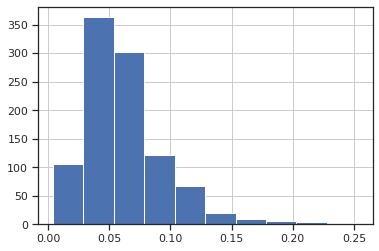

In [102]:
df_a['acquisition_mean'].hist()

<Figure size 432x288 with 0 Axes>

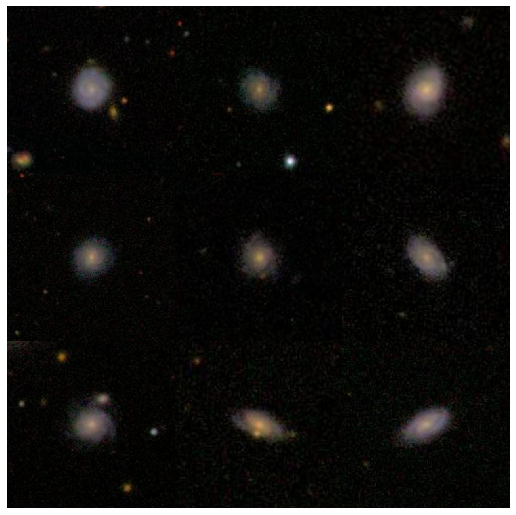

In [103]:
_ = show_galaxies(df_a.sort_values('acquisition_mean'))

<Figure size 432x288 with 0 Axes>

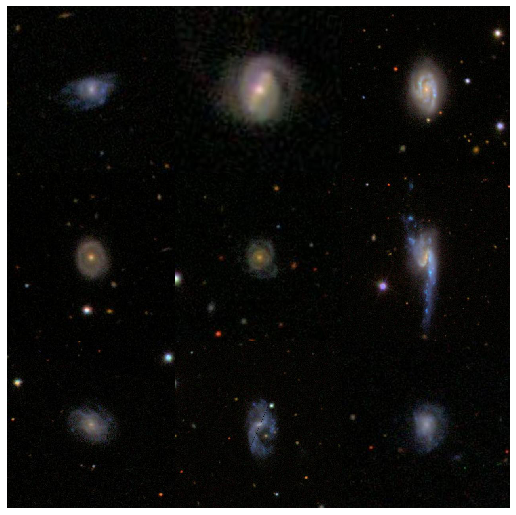

In [104]:
_ = show_galaxies(df_a.sort_values('acquisition_mean', ascending=False))

<Figure size 432x288 with 0 Axes>

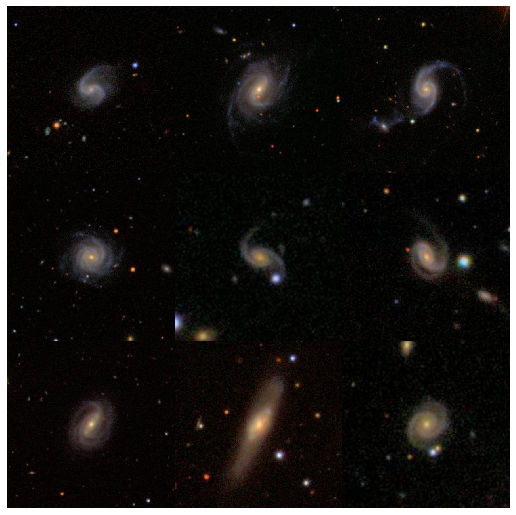

In [105]:
_ = show_galaxies(df_a.sort_values('smooth-or-featured_acquisition'))

<Figure size 432x288 with 0 Axes>

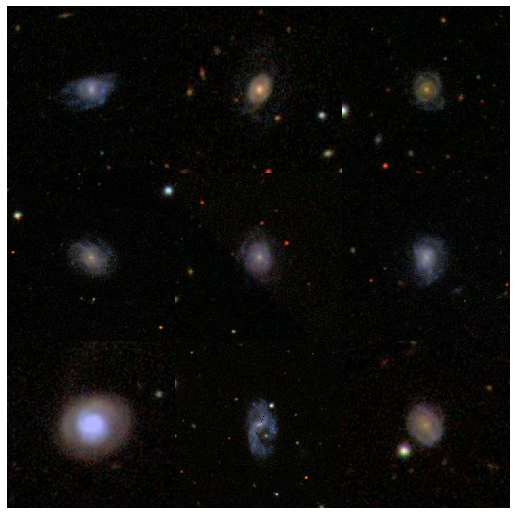

In [106]:
_ = show_galaxies(df_a.sort_values('smooth-or-featured_acquisition', ascending=False))

<Figure size 432x288 with 0 Axes>

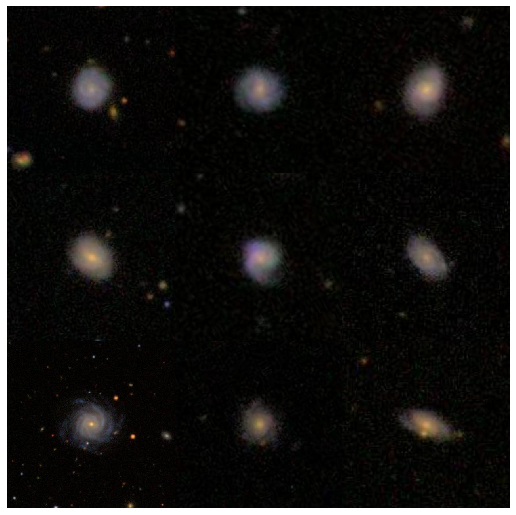

In [107]:
_ = show_galaxies(df_a.sort_values('has-spiral-arms_acquisition'))

<Figure size 432x288 with 0 Axes>

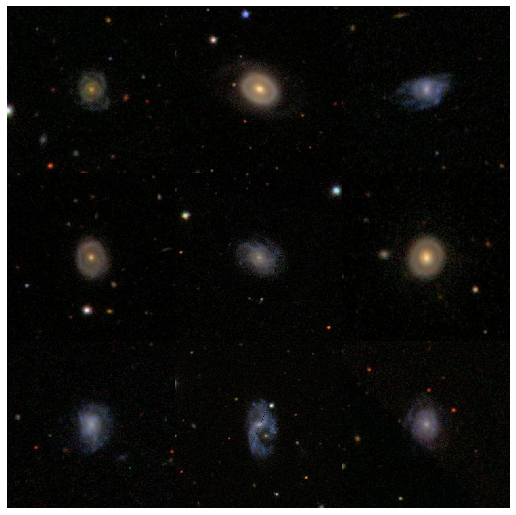

In [108]:
_ = show_galaxies(df_a.sort_values('has-spiral-arms_acquisition', ascending=False))

Failed to find  /media/walml/beta/gz2/png/587739406229045443.png


<Figure size 432x288 with 0 Axes>

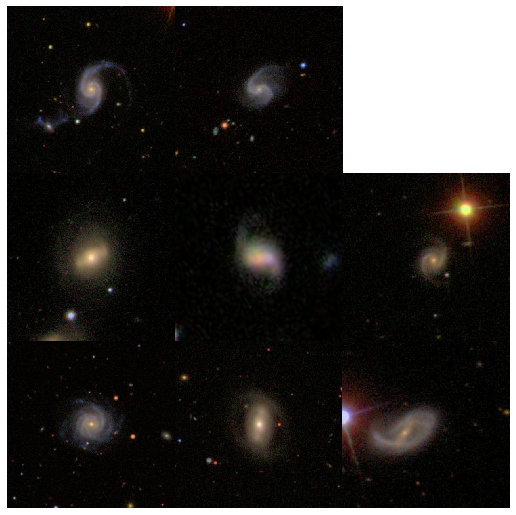

In [128]:
_ = show_galaxies(df_a.sort_values('bar_acquisition', ascending=False))

<Figure size 432x288 with 0 Axes>

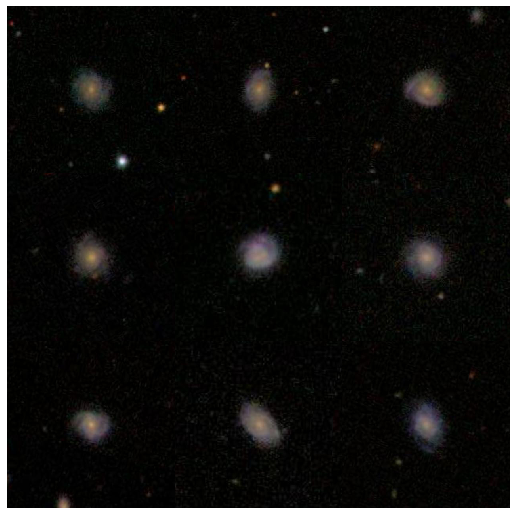

In [109]:
_ = show_galaxies(df_a.sort_values('bar_acquisition'))

<Figure size 432x288 with 0 Axes>

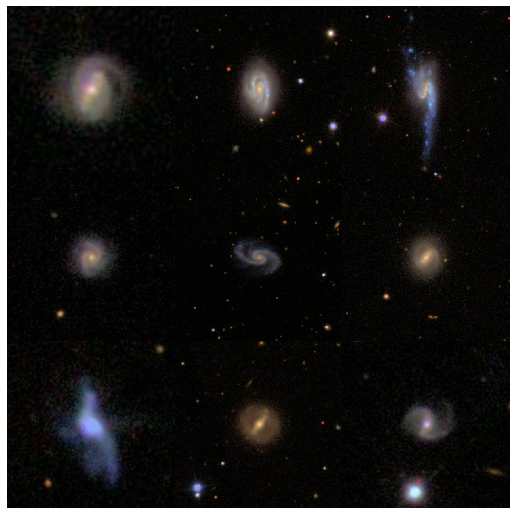

In [113]:
_ = show_galaxies(df_a.sort_values('bulge-size_acquisition', ascending=False))

<Figure size 432x288 with 0 Axes>

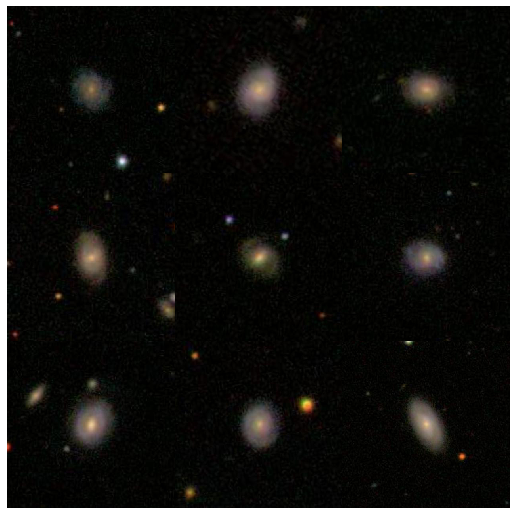

In [112]:
_ = show_galaxies(df_a.sort_values('bulge-size_acquisition'))